# Problema do Avião

O Problema de Otimização do Carregamento de um Avião de Carga, similarmente ao Problema da Garrafa, é um "problema brinquedo" de otimização utilizado como exemplo prático de aplicação de Algoritmos Genéticos.

O problema é apresentado com detalhes [aqui](aviao2020.pdf).

In [1]:
import numpy as np
import pandas as pd
import random

import inspyred
from inspyred import ec
from inspyred.ec import terminators, selectors, observers, evaluators, replacers, generators

import warnings
warnings.filterwarnings('ignore')

A representação do cromossomo escolhida foi binária, e a inicialização da população ocorre de maneira aleatória.

In [2]:
# Generates random individuals
@generators.diversify
def generate(random, args):
    num_genes = args.get('num_genes')
    bits = args.get('num_bits')
    
    return [np.random.choice([0, 1]) for i in range(num_genes * bits)]

O método seguinte é responsável por calcular o fitness, que reflete o lucro de um determinado carregamento do avião. A penalidade aplicada é discutida com mais detalhes na próxima seção. A função objetivo a ser maximizada (lucro) é obtida por:

$$\frac{(C_1 \cdot 0.82) + (C_2 \cdot 1.15) + (C_3 \cdot 0.92) + (C_4 \cdot 0.75)}{250000 \cdot 1.15}$$

Onde $C_i$ corresponde ao peso em kg da Carga $i$. A constante $250000 \cdot 1.15$ representa o lucro máximo teórico (produto da capacidade máxima de peso pelo maior valor de lucro/kg), de forma a normalizar o resultado no intervalo $[0, 1]$.

Nota: o ótimo global para este problema (maior lucro) provavelmente está bem abaixo do máximo teórico que foi estipulado. Isso implica que, na prática, o valor da função objetivo, mesmo sem penalidades, nunca chegará perto de $1$. Isso também quer dizer que o valor da penalidade pode, com certa facilidade, ser maior que o da função objetivo. Visto que o modo de seleção por torneio não tem problemas em lidar com valores negativos de fitness, isso não é um problema.

In [3]:
# Evaluates an individual
@evaluators.evaluator
def evaluate(candidate, args):
    num_genes = args.get('num_genes')
    bits = args.get('num_bits')

    # Get integer representation of genes for easier calculations
    genes_int = integer_rep(candidate, num_genes)
        
    # Calculate fitness function
    fit = np.dot([genes_int[0::4].sum(), genes_int[1::4].sum(), genes_int[2::4].sum(), genes_int[3::4].sum()], [0.82, 1.15, 0.92, 0.75])
    fit = fit / (250000 * 1.15)
        
    # Apply penalties and return result
    return fit - penalty(genes_int)

Esse problema conta com um total de 10 restrições. O avião não deve exceder sua capacidade máxima de peso ou volume em nenhum de seus 3 compartimentos. Cada tipo de carga também tem uma disponibilidade máxima em peso que, obviamente, não deve ser excedida. Cada uma dessas penalidades pode assumir um valor dentro do intervalo $[0, 1]$ e são calculadas por:

Capacidade de peso do compartimento dianteiro:
$$\hat h_1 =  \frac{\text{max}\{0, P_d - 77500\}}{77500}$$

Capacidade de volume do compartimento dianteiro:
$$\hat h_2 =  \frac{\text{max}\{0, V_d - 545\}}{450}$$

Capacidade de peso do compartimento central:
$$\hat h_3 =  \frac{\text{max}\{0, P_c - 115000\}}{115000}$$

Capacidade de volume do compartimento central:
$$\hat h_4 =  \frac{\text{max}\{0, V_c - 545\}}{545}$$

Capacidade de peso do compartimento traseiro:
$$\hat h_5 =  \frac{\text{max}\{0, P_t - 57500\}}{57500}$$

Capacidade de volume do compartimento traseiro:
$$\hat h_6 =  \frac{\text{max}\{0, V_t - 545\}}{305}$$

Disponibilidade da Carga 1:
$$\hat h_7 = \frac{\text{max}\{0, C_1 - 66000\}}{66000}$$

Disponibilidade da Carga 2:
$$\hat h_8 = \frac{\text{max}\{0, C_2 - 55000\}}{55000}$$

Disponibilidade da Carga 3:
$$\hat h_9 = \frac{\text{max}\{0, C_3 - 85000\}}{85000}$$

Disponibilidade da Carga 4:
$$\hat h_{10} = \frac{\text{max}\{0, C_4 - 40000\}}{40000}$$

Onde $P_d, P_c, P_t$ são, respectivamente, a capacidade de peso utilizada dos compartimentos dianteiro, central e traseiro; $V_d, V_c, V_t$ representam a ocupação da capacidade volumétrica de seus respectivos compartimentos; $C_i$ corresponde ao peso da Carga $i$ que foi carregado no avião.

O cálculo da penalidade total se dá por:

$$ \frac{\sum_{i=1}^{10} \hat h_i}{2}$$

Onde 2 é uma constante encontrada empíricamente para ajustar o peso da penalidade aplicada à função objetivo.

In [4]:
# Calculates fitness penalties
def penalty(genes_int):
    vol = np.array([7.75, 10.60, 8.36, 6.30])
    
    h1 = max(0, np.sum(genes_int[:4]) - 77500) / 77500
    h2 = max(0, (np.dot(genes_int[:4], vol)) / 1000 - 450) / 450
                         
    h3 = max(0, np.sum(genes_int[4:8]) - 115000) / 115000
    h4 = max(0, (np.dot(genes_int[4:8], vol)) / 1000 - 545) / 545
                         
    h5 = max(0, np.sum(genes_int[8:]) - 57500) / 57500
    h6 = max(0, (np.dot(genes_int[8:], vol)) / 1000 - 305) / 305
                         
    h7 = max(0, np.sum(genes_int[0::4]) - 66000) / 66000
    h8 = max(0, np.sum(genes_int[1::4]) - 55000) / 55000
    h9 = max(0, np.sum(genes_int[2::4]) - 85000) / 85000
    h10 = max(0, np.sum(genes_int[3::4]) - 40000) / 40000
    
    return (h1 + h2 + h3 + h4 + h5 + h6 + h7 + h8 + h9 + h10) / 2

Esse método retorna transforma a representação binária em uma representação com números inteiros:

In [5]:
# Returns integer representation of a given individual's genes
def integer_rep(genes, num_genes=12):
    genes = np.array_split(genes, num_genes)
    genes_int = []
    for g in genes:
        genes_int.append(int("".join([str(bit) for bit in g]), 2))
        
    return np.array(genes_int)

Aqui acontece o processo de evolução do Algoritmo Genético. Todos seus parâmetros são configurados nessa seção. Depois da execução, a função retorna o melhor indivíduo.

In [6]:
# Genetic Algorithm declaration and process of evolution
def main():
    rand = random.Random()
    
    pop_size = 250

    ga = inspyred.ec.GA(rand)
    ga.observer = [observers.stats_observer, observers.plot_observer]
    ga.terminator = terminators.generation_termination
    ga.selector = selectors.tournament_selection
    ga.replacer = replacers.crowding_replacement

    final_pop = ga.evolve(generator=generate,
                          evaluator=evaluate,
                          tournament_size=3,
                          max_generations=100,
                          crossover_rate=0.4,
                          mutation_rate=0.1,
                          num_crossover_points=2,
                          pop_size=pop_size,
                          num_elites=1,
                          num_genes=12,
                          num_bits=17)

    return max(final_pop)

Obtém-se o melhor indivíduo após o término da execução. O gráfico de fitness é apresentado para acompanhar como se deu a evolução da população.

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         0        250 -21.035821 -4.0438186 -12.442332 -12.397126 3.20049488

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         1        500 -21.035821 -3.1523004 -9.9491108 -10.346544 3.15402768

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         2        750 -18.026197 -3.1523004 -8.3014445 -8.7781270 3.01189981

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         3       1000 -17.945032 -2.0282207 -7.0122978 -7.4157638 2.77076436

Generation Evaluation      Worst       Best     Median    Average    Std

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
        36       9250 -0.7959297 0.44198196 0.10986114 0.03705284 0.28405206

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
        37       9500 -0.7959297 0.44198196 0.11093880 0.04415974 0.27732609

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
        38       9750 -0.7959297 0.44354101 0.13231924 0.06931132 0.26947228

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
        39      10000 -0.7689708 0.44354101 0.16243297 0.09727562 0.25299425

Generation Evaluation      Worst       Best     Median    Average    Std

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
        72      18250 -0.2615793 0.48526584 0.37653762 0.35170665 0.10203946

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
        73      18500 -0.2615793 0.48526584 0.37711752 0.35244772 0.10194712

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
        74      18750 -0.2615793 0.48526584 0.37957948 0.35598798 0.10158982

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
        75      19000 -0.2615793 0.48526584 0.38072450 0.35824143 0.09722439

Generation Evaluation      Worst       Best     Median    Average    Std

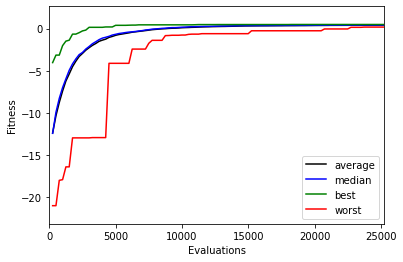

In [7]:
if __name__ == '__main__':
    best = main()
    best_ind = integer_rep(best.candidate)

Por fim, faz-se alguma manipulação na codificação do cromossomo para obter dados facilmente interpretáveis e informativos sobre a solução encontrada. Ao final de tudo, podemos verificar se a solução ultrapassou algum dos limites (restrições), e o lucro que ela obteve.

In [10]:
    vols = np.array([7.75, 10.60, 8.36, 6.30])
    prices = np.array([0.82, 1.15, 0.92, 0.75])
    
    comp_d, comp_c, comp_t = best_ind[:4], best_ind[4:8], best_ind[8:]
    vol_d, vol_c, vol_t = np.array([np.dot(comp_d, vols), np.dot(comp_c, vols), np.dot(comp_t, vols)]) / 1000
    
    c1, c2, c3, c4 = best_ind[0::4], best_ind[0::4], best_ind[2::4], best_ind[3::4]
    
    df = pd.DataFrame({'Comp. Dianteiro': comp_d, 'Comp. Central': comp_c, 'Comp. Traseiro': comp_t},
                      index=['Peso Carga 1', 'Peso Carga 2', 'Peso Carga 3', 'Peso Carga 4'])
    df.loc['Total',:]= df.sum(axis=0)
    df.loc[:,'Total'] = df.sum(axis=1)
    display(df)

    df = pd.DataFrame({'Comp. Dianteiro': vol_d, 'Comp. Central': vol_c, 'Comp. Traseiro': vol_t},
                      index=['Volume'])
    display(df)
    
    print()
    print("Utilização da capacidade máxima dos compartimentos:")
    print(f"Dianteiro \t Peso: {comp_d.sum() / 77500 * 100:.2f}% \t Volume {vol_d / 450 * 100:.2f}%")
    print(f"Central \t Peso: {comp_c.sum() / 115000 * 100:.2f}% \t Volume {vol_c / 545 * 100:.2f}%")
    print(f"Traseiro \t Peso: {comp_t.sum() / 57500 * 100:.2f}% \t Volume {vol_t / 305 * 100:.2f}%")
    
    print("\nUtilização da quantidade disponível de cargas:")
    print(f"Carga 1 \t {c1.sum() / 66000 * 100:.2f}%")
    print(f"Carga 2 \t {c2.sum() / 55000 * 100:.2f}%")
    print(f"Carga 3 \t {c3.sum() / 85000 * 100:.2f}%")
    print(f"Carga 4 \t {c4.sum() / 40000 * 100:.2f}%")
    
    print(f"\nLucro total: {np.dot([sum(c1), sum(c2), sum(c3), sum(c4)], prices):.2f}")

,Comp. Dianteiro,Comp. Central,Comp. Traseiro,Total
Peso Carga 1,9078.0,19209.0,11424.0,39711.0
Peso Carga 2,21388.0,9121.0,3430.0,33939.0
Peso Carga 3,13885.0,28832.0,9101.0,51818.0
Peso Carga 4,3857.0,8084.0,15057.0,26998.0
Total,48208.0,65246.0,39012.0,152466.0


,Comp. Dianteiro,Comp. Central,Comp. Traseiro
Volume,437.445,537.51707,295.83746



Utilização da capacidade máxima dos compartimentos:
Dianteiro 	 Peso: 62.20% 	 Volume 97.21%
Central 	 Peso: 56.74% 	 Volume 98.63%
Traseiro 	 Peso: 67.85% 	 Volume 97.00%

Utilização da quantidade disponível de cargas:
Carga 1 	 60.17%
Carga 2 	 72.20%
Carga 3 	 60.96%
Carga 4 	 67.50%

Lucro total: 146151.73
